In [21]:
!pip install torchvision

     |████████████████████████████████| 19.1 MB 15.3 MB/s eta 0:00:01


In [1]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests
import csv

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [2]:
def parseName(name):
    elts = name.split('-')
    data.append([elts[-2]])

In [3]:
model_checkpoint = "google/vit-base-patch16-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [5]:
from datasets import load_dataset 

dataset = load_dataset("imagefolder", data_dir="categories")



Resolving data files:   0%|          | 0/1999 [00:00<?, ?it/s]

Using custom data configuration default-693de55f57cea8dd


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/jovyan/.cache/huggingface/datasets/imagefolder/default-693de55f57cea8dd/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
dataset["train"][998]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FFA15CF8CA0>,
 'label': 0}

In [7]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-7-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


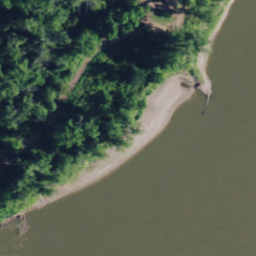

In [8]:
example = dataset["train"][10]
example
example['image']

In [9]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=2, names=['rien', 'silo'], id=None)}

In [10]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[0]

'rien'

In [11]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [12]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [13]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [14]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [15]:
len(train_ds)

1799

In [16]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    #push_to_hub=True,
)

In [18]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [19]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [20]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [21]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1799
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 42


Epoch,Training Loss,Validation Loss,Accuracy
0,0.730500,0.363141,0.865000
1,0.415200,0.231448,0.920000
2,0.301600,0.225940,0.920000


***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
Saving model checkpoint to vit-base-patch16-224-finetuned-eurosat/checkpoint-14
Configuration saved in vit-base-patch16-224-finetuned-eurosat/checkpoint-14/config.json
Model weights saved in vit-base-patch16-224-finetuned-eurosat/checkpoint-14/pytorch_model.bin
Feature extractor saved in vit-base-patch16-224-finetuned-eurosat/checkpoint-14/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
Saving model checkpoint to vit-base-patch16-224-finetuned-eurosat/checkpoint-28
Configuration saved in vit-base-patch16-224-finetuned-eurosat/checkpoint-28/config.json
Model weights saved in vit-base-patch16-224-finetuned-eurosat/checkpoint-28/pytorch_model.bin
Feature extractor saved in vit-base-patch16-224-finetuned-eurosat/checkpoint-28/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
Saving model checkpoint to vit-base-patch16-224-finetune

***** train metrics *****
  epoch                    =        2.98
  total_flos               = 388996511GF
  train_loss               =      0.4438
  train_runtime            =  0:18:55.52
  train_samples_per_second =       4.753
  train_steps_per_second   =       0.037


In [22]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


***** eval metrics *****
  epoch                   =       2.98
  eval_accuracy           =       0.92
  eval_loss               =     0.2314
  eval_runtime            = 0:00:13.14
  eval_samples_per_second =     15.215
  eval_steps_per_second   =      0.533


In [57]:
from PIL import Image
import requests
image = Image.open("silo7.png")
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [95]:
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [89]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: rien


In [103]:
torch.save(model.state_dict(), "modele.pt")